###  Data Loading & Preprocessing

We begin by importing the necessary libraries and loading the training and test datasets. We check their dimensions and preview the first few rows to understand the structure and types of features. 

Then, to be able work with the target variable 'Risk_Label', we use LabelEncoder from sklearn.preprocessing to convert these string labels into numeric values. And we seperate the target lable from data to be able to train and test our model.





In [12]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder


# Load the datasets
train_df = pd.read_csv("dataset/train_credit_data.csv")
test_df = pd.read_csv("dataset/test_credit_data.csv")

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
train_df.head()

# Copy to avoid modifying original data
train_data = train_df.copy()
test_data = test_df.copy()

# Label encode the target variable
le = LabelEncoder()
train_data['Risk_Label'] = le.fit_transform(train_data['Risk_Label'])
test_data['Risk_Label'] = le.transform(test_data['Risk_Label'])

# Separate features and labels
X_train = train_data.drop("Risk_Label", axis=1)
y_train = train_data["Risk_Label"]

X_test = test_data.drop("Risk_Label", axis=1)
y_test = test_data["Risk_Label"]

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_train.shape)

X_train.head()




Train shape: (3772, 13)
Test shape: (3428, 13)
Train shape: (3772, 12) (3772,)
Test shape: (3428, 12) (3772,)


,Income,DebtToIncome,CreditHistory,LatePayments,Employment,CreditLines,LoanAmount,HomeOwnership,Age,Savings,Education,ReliabilityScore
0,101.692304,6.046014,12.538993,2,3.371397,2,223.749888,0,29.654235,63.632573,3,4.387126
1,65.263115,20.920108,16.524981,2,2.558994,4,39.948799,1,42.493071,61.098483,2,5.378843
2,83.760685,20.932257,6.834911,0,5.294267,2,206.694898,1,41.379374,82.461972,4,7.623962
3,73.293188,16.535676,12.673553,0,1.043815,4,120.734710,1,50.546432,80.630408,2,12.795080
4,76.857072,19.444921,10.359301,2,0.000000,7,97.532696,0,29.366066,39.001485,3,3.478817


## 1️⃣ Part 1 

### 1.1 Train and Tune a Decision Tree Classifier

We train a decision tree classifier using GridSearchCV to automatically find the best hyperparameters (criterion, max_depth, and min_samples_split) via cross-validation on the training data. We use 5-fold cross-validation to test all combinations of these parameters on the training data. Below are the hyper-parameters we tune for:

<ul>
<li>criterion</li>
<li>max_depth</li>
<li>min_samples_split</li>
</ul>

In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Define the model and parameters to tune
dt = DecisionTreeClassifier(random_state=42)
params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [1,2,3,4,5,6,7,8,9, 10, 15, 20, None],
    'min_samples_split': [2, 3, 4, 5, 10, 20]
}

# Cross-validation to find the best hyperparameters
grid = GridSearchCV(dt, params, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)


Best parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 2}


### 1.2  Evaluate the Model
We now evaluate the performance of the best decision tree model found by GridSearchCV. We measure:

<ul>
<li>Accuracy: The overall percentage of correct predictions.</li>
<li>Class-based metrics: Precision, recall, and F1-score for each class.</li>
<li>Confusion matrix: To visualize the distribution of true vs predicted classes.</li>
</ul>



In [29]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

# Best pruned model from grid search
best_dt = grid.best_estimator_

# Predictions
y_pred_train = best_dt.predict(X_train)
y_pred_test = best_dt.predict(X_test)

# --- 1) Overall accuracy ---
train_acc = accuracy_score(y_train, y_pred_train)
test_acc = accuracy_score(y_test, y_pred_test)

print(f"🔹 Training Accuracy (Pruned): {train_acc:.4f}")
print(f"🔹 Test Accuracy (Pruned):     {test_acc:.4f}")

# --- 2) Confusion matrices ---
conf_matrix_train = confusion_matrix(y_train, y_pred_train)
conf_matrix_test = confusion_matrix(y_test, y_pred_test)

print("\n📊 Training Confusion Matrix:")
print(conf_matrix_train)

print("\n📊 Test Confusion Matrix:")
print(conf_matrix_test)

# --- 3) Class-based accuracy ---
def class_based_accuracy(cm):
    accs = {}
    for i, label in enumerate(le.classes_):
        correct = cm[i, i]
        total_actual = cm[i].sum()
        accs[label] = correct / total_actual
    return accs

train_class_acc = class_based_accuracy(conf_matrix_train)
test_class_acc = class_based_accuracy(conf_matrix_test)

print("\n📈 Class-based Accuracy (Training Set):")
for label, acc in train_class_acc.items():
    print(f"{label:>8}: {acc:.4f}")

print("\n📈 Class-based Accuracy (Test Set):")
for label, acc in test_class_acc.items():
    print(f"{label:>8}: {acc:.4f}")


🔹 Training Accuracy (Pruned): 0.9828
🔹 Test Accuracy (Pruned):     0.9781

📊 Training Confusion Matrix:
[[1898   24    0]
 [   0 1230    0]
 [  41    0  579]]

📊 Test Confusion Matrix:
[[1683   33    0]
 [   1 1136    0]
 [  40    1  534]]

📈 Class-based Accuracy (Training Set):
 Average: 0.9875
    Good: 1.0000
    Poor: 0.9339

📈 Class-based Accuracy (Test Set):
 Average: 0.9808
    Good: 0.9991
    Poor: 0.9287


### 1.3 Visualize the Decision Tree


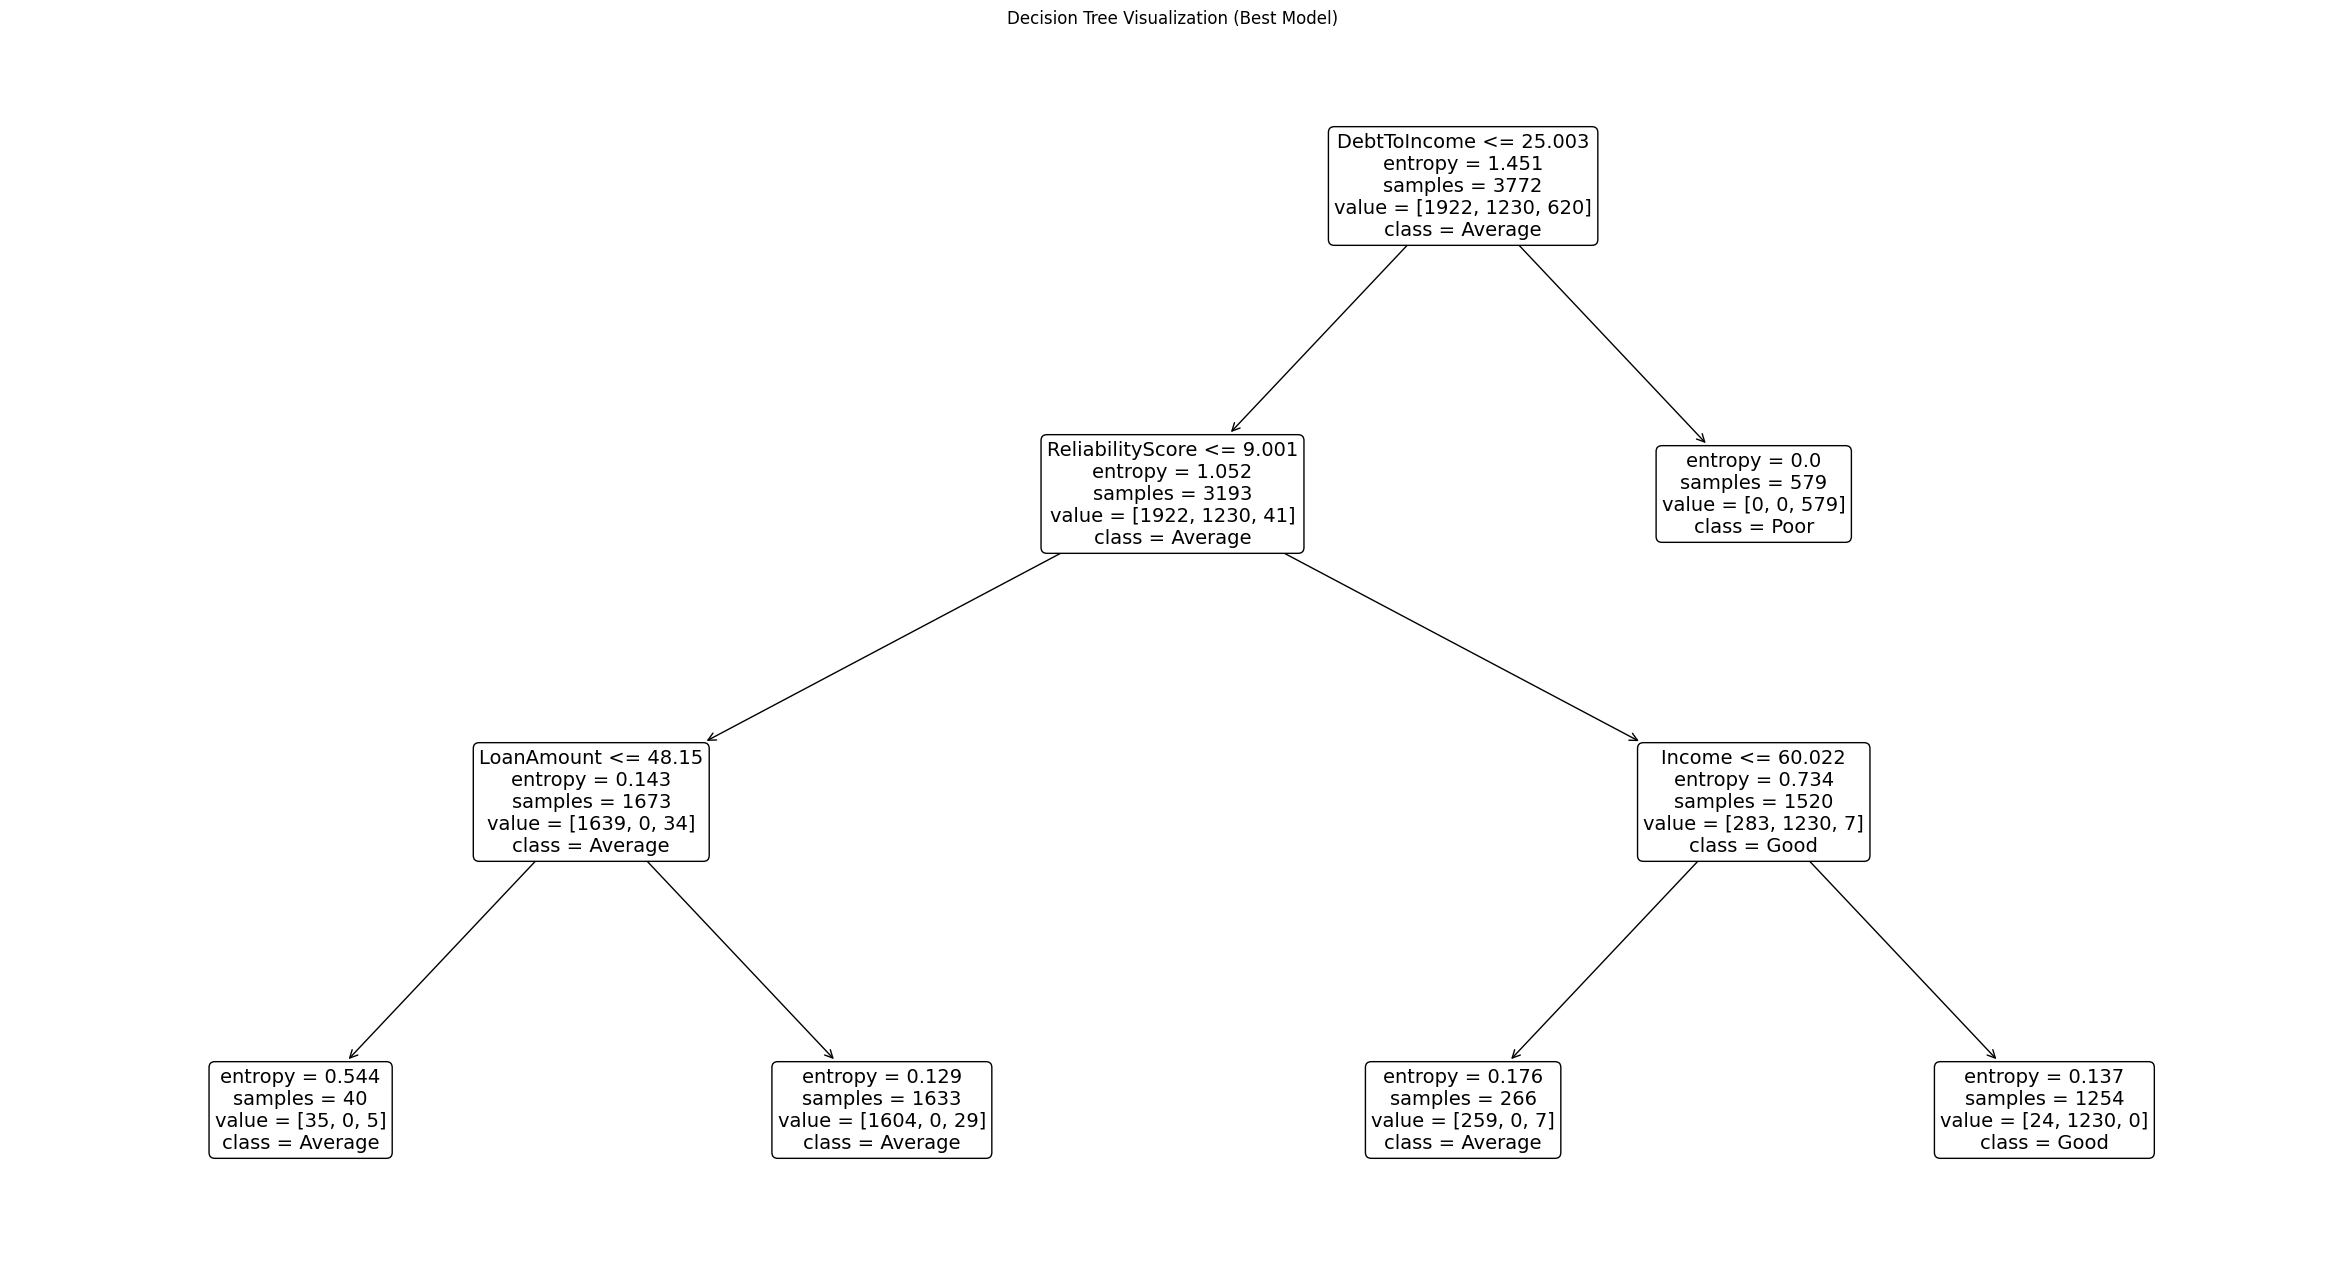

In [26]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

feature_names = X_train.columns
class_names = le.classes_

# Plot the decision tree
plt.figure(figsize=(30, 16)) 
plot_tree(
    best_dt,
    feature_names=feature_names,
    class_names=class_names,
    filled=False,
    rounded=True,
    fontsize=14,
)
plt.title("Decision Tree Visualization (Best Model)")
plt.show()


### 1.4 Pruning vs No-Pruning

We continue with comparing the class-based performance of:

<ul>
<li>A pre-pruned decision tree (hyperparameters tuned using GridSearchCV in section 1.1)</li> 
<li>A fully-grown tree trained without restrictions</li>
</ul>


This helps us understand the effect of pre-pruning on overfitting and generalization.

In [28]:
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np

# Train unpruned decision tree
unpruned_dt = DecisionTreeClassifier(random_state=42)
unpruned_dt.fit(X_train, y_train)

# Predictions
y_pred_train_unpruned = unpruned_dt.predict(X_train)
y_pred_test_unpruned = unpruned_dt.predict(X_test)

# --- 1) Overall accuracy ---
train_acc_unpruned = accuracy_score(y_train, y_pred_train_unpruned)
test_acc_unpruned = accuracy_score(y_test, y_pred_test_unpruned)

print(f"🔹 Training Accuracy (Unpruned): {train_acc_unpruned:.4f}")
print(f"🔹 Test Accuracy (Unpruned):     {test_acc_unpruned:.4f}")

# --- 2) Confusion matrices ---
conf_matrix_train = confusion_matrix(y_train, y_pred_train_unpruned)
conf_matrix_test = confusion_matrix(y_test, y_pred_test_unpruned)

print("\n📊 Training Confusion Matrix:")
print(conf_matrix_train)

print("\n📊 Test Confusion Matrix:")
print(conf_matrix_test)

# --- 3) Class-based accuracy ---
def class_based_accuracy(cm):
    accs = {}
    for i, label in enumerate(le.classes_):
        correct = cm[i, i]
        total_actual = cm[i].sum()
        accs[label] = correct / total_actual
    return accs

train_class_acc = class_based_accuracy(conf_matrix_train)
test_class_acc = class_based_accuracy(conf_matrix_test)

print("\n📈 Class-based Accuracy (Training Set):")
for label, acc in train_class_acc.items():
    print(f"{label:>8}: {acc:.4f}")

print("\n📈 Class-based Accuracy (Test Set):")
for label, acc in test_class_acc.items():
    print(f"{label:>8}: {acc:.4f}")


🔹 Training Accuracy (Unpruned): 1.0000
🔹 Test Accuracy (Unpruned):     0.9589

📊 Training Confusion Matrix:
[[1922    0    0]
 [   0 1230    0]
 [   0    0  620]]

📊 Test Confusion Matrix:
[[1642   31   43]
 [  27 1110    0]
 [  40    0  535]]

📈 Class-based Accuracy (Training Set):
 Average: 1.0000
    Good: 1.0000
    Poor: 1.0000

📈 Class-based Accuracy (Test Set):
 Average: 0.9569
    Good: 0.9763
    Poor: 0.9304


### 1.5 Normalization vs. No Normalization

In this experiment, we evaluate whether applying min-max normalization to feature values affects the performance of a decision tree. Although decision trees are invariant to feature scaling, we run this comparison to confirm whether normalization has any unexpected effects on performance.

We use the same hyperparameters from the best model obtained earlier.

In [48]:
from sklearn.preprocessing import MinMaxScaler

# 1. Normalize features using MinMaxScaler
scaler = MinMaxScaler()
X_train_norm = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_norm = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# 2. Train decision tree using same best hyperparameters
dt_norm = DecisionTreeClassifier(**grid.best_params_, random_state=42)
dt_norm.fit(X_train_norm, y_train)

# 3. Predictions
y_pred_train_norm = dt_norm.predict(X_train_norm)
y_pred_test_norm = dt_norm.predict(X_test_norm)

# --- 4) Accuracy ---
train_acc_norm = accuracy_score(y_train, y_pred_train_norm)
test_acc_norm = accuracy_score(y_test, y_pred_test_norm)

print(f"🔹 Training Accuracy (Normalized): {train_acc_norm:.4f}")
print(f"🔹 Test Accuracy (Normalized):     {test_acc_norm:.4f}")

# --- 5) Confusion matrices ---
conf_matrix_train_norm = confusion_matrix(y_train, y_pred_train_norm)
conf_matrix_test_norm = confusion_matrix(y_test, y_pred_test_norm)

print("\n📊 Training Confusion Matrix:")
print(conf_matrix_train_norm)

print("\n📊 Test Confusion Matrix:")
print(conf_matrix_test_norm)

# --- 6) Class-based accuracy ---
def class_based_accuracy(cm):
    accs = {}
    for i, label in enumerate(le.classes_):
        correct = cm[i, i]
        total_actual = cm[i].sum()
        accs[label] = correct / total_actual
    return accs

train_class_acc_norm = class_based_accuracy(conf_matrix_train_norm)
test_class_acc_norm = class_based_accuracy(conf_matrix_test_norm)

print("\n📈 Class-based Accuracy (Training Set):")
for label, acc in train_class_acc_norm.items():
    print(f"{label:>8}: {acc:.4f}")

print("\n📈 Class-based Accuracy (Test Set):")
for label, acc in test_class_acc_norm.items():
    print(f"{label:>8}: {acc:.4f}")




🔹 Training Accuracy (Normalized): 0.9828
🔹 Test Accuracy (Normalized):     0.9781

📊 Training Confusion Matrix:
[[1898   24    0]
 [   0 1230    0]
 [  41    0  579]]

📊 Test Confusion Matrix:
[[1683   33    0]
 [   1 1136    0]
 [  40    1  534]]

📈 Class-based Accuracy (Training Set):
 Average: 0.9875
    Good: 1.0000
    Poor: 0.9339

📈 Class-based Accuracy (Test Set):
 Average: 0.9808
    Good: 0.9991
    Poor: 0.9287


### 1.6 Class Inbalance & Undersampling

The original training set has an imbalanced distribution of class labels — some classes have significantly more instances than others. This can cause the decision tree to be biased toward the majority classes.

We apply random undersampling to the majority classes to match the size of the minority class (Poor). Then we retrain the decision tree using the same best hyperparameters and compare the evaluation metrics to the model trained on the imbalanced data.

In [58]:
from sklearn.utils import resample

# Combine X_train and y_train
train_combined = pd.concat([X_train, y_train], axis=1)

# Get counts of each class
class_counts = train_combined['Risk_Label'].value_counts()
minority_class_size = class_counts.min()

# print number of data for each class 
print("🔢 Class Counts:")
for idx, label in enumerate(le.classes_):
    print(f"{idx}: {label} - {class_counts[idx]}")


# Undersample each class to match the minority class
balanced_dfs = []
for label in class_counts.index:
    class_subset = train_combined[train_combined['Risk_Label'] == label]
    downsampled_subset = resample(
        class_subset,
        replace=False,
        n_samples=minority_class_size,
        random_state=42
    )
    balanced_dfs.append(downsampled_subset)

# Combine and shuffle
train_balanced = pd.concat(balanced_dfs).sample(frac=1, random_state=42)

# Split features and labels
X_train_bal = train_balanced.drop("Risk_Label", axis=1)
y_train_bal = train_balanced["Risk_Label"]

# Train a decision tree on balanced data
dt_bal = DecisionTreeClassifier(**grid.best_params_, random_state=42)
dt_bal.fit(X_train_bal, y_train_bal)

# Predict on original test set
y_pred_train_bal = dt_bal.predict(X_train_bal)
y_pred_test_bal = dt_bal.predict(X_test)

# --- Accuracy ---
train_acc_bal = accuracy_score(y_train_bal, y_pred_train_bal)
test_acc_bal = accuracy_score(y_test, y_pred_test_bal)

print(f"\n🔹 Training Accuracy (Balanced): {train_acc_bal:.4f}")
print(f"🔹 Test Accuracy (Balanced):     {test_acc_bal:.4f}")

# --- Confusion matrices ---
conf_matrix_train_bal = confusion_matrix(y_train_bal, y_pred_train_bal)
conf_matrix_test_bal = confusion_matrix(y_test, y_pred_test_bal)

print("\n📊 Training Confusion Matrix (Balanced):")
print(conf_matrix_train_bal)

print("\n📊 Test Confusion Matrix (Balanced):")
print(conf_matrix_test_bal)

# --- Class-based accuracy ---
def class_based_accuracy(cm):
    accs = {}
    for i, label in enumerate(le.classes_):
        correct = cm[i, i]
        total_actual = cm[i].sum()
        accs[label] = correct / total_actual
    return accs

train_class_acc_bal = class_based_accuracy(conf_matrix_train_bal)
test_class_acc_bal = class_based_accuracy(conf_matrix_test_bal)

print("\n📈 Class-based Accuracy (Training Set, Balanced):")
for label, acc in train_class_acc_bal.items():
    print(f"{label:>8}: {acc:.4f}")

print("\n📈 Class-based Accuracy (Test Set, Balanced):")
for label, acc in test_class_acc_bal.items():
    print(f"{label:>8}: {acc:.4f}")


🔢 Class Counts:
0: Average - 1922
1: Good - 1230
2: Poor - 620

🔹 Training Accuracy (Balanced): 0.9731
🔹 Test Accuracy (Balanced):     0.9772

📊 Training Confusion Matrix (Balanced):
[[611   9   0]
 [  0 620   0]
 [ 41   0 579]]

📊 Test Confusion Matrix (Balanced):
[[1682   33    1]
 [   4 1133    0]
 [  40    0  535]]

📈 Class-based Accuracy (Training Set, Balanced):
 Average: 0.9855
    Good: 1.0000
    Poor: 0.9339

📈 Class-based Accuracy (Test Set, Balanced):
 Average: 0.9802
    Good: 0.9965
    Poor: 0.9304
